
## Imports

In [6]:
# !pip install gym[box2d]
# !pip install imageio-ffmpeg
# !pip install pyvirtualdisplay

In [7]:


# %%bash
# sudo apt-get install -y xvfb python-opengl > /dev/null 2>&1
# pip install pyvirtualdisplay > /dev/null 2>&1
# pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [8]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils
from learning import calculate_loss

from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [9]:
# Use in Jupyter Notebook
Display(visible=0, size=(840, 480)).start();

tf.random.set_seed(utils.SEED)


## Hyperparameters

In [10]:
MEMORY_SIZE = 100_000
GAMMA = 0.995        
ALPHA = 1e-3           
NUM_STEPS_FOR_UPDATE = 4 


## Get Gym Environment

In [11]:
env = gym.make('Acrobot-v1')

/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."


/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "


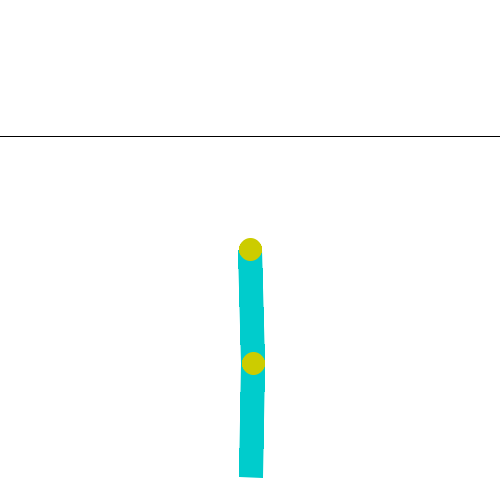

In [12]:
env.reset()

# Use in Jupyter Notebook
PIL.Image.fromarray(env.render(mode='rgb_array'))


## Explore the environment

In [13]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (6,)
Number of actions: 3


In [14]:
initial_state = env.reset()

In [15]:
action = 0

next_state, reward, done, _ = env.step(action)

utils.display_table(initial_state, action, next_state, reward, done)

Initial State:,[1.000 -0.029 0.999 0.052 0.006 0.094]
Action:,Do nothing
Next State:,[1.000 -0.010 1.000 0.028 0.180 -0.328]
Reward Received:,-1.000
Episode Terminated:,False



## Create the Q-Network, the target Q-Network and the optimizer

In [16]:

q_network = Sequential([
    Input(shape=state_size),                      
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ])

target_q_network = Sequential([
    Input(shape=state_size),                       
    Dense(units=64, activation='relu'),            
    Dense(units=64, activation='relu'),            
    Dense(units=num_actions, activation='linear'), 
    ])

optimizer = Adam(learning_rate=ALPHA)   


In [17]:
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])


## Get gradients of the loss and update the weights

In [18]:
@tf.function
def learn(experiences, gamma):
    """
    Updates the weights of the Q networks.
    
    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
    
    """
    
    with tf.GradientTape() as tape:
        loss = calculate_loss(experiences, gamma, q_network, target_q_network)

    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    utils.update_target_network(q_network, target_q_network)


## Training Loop - Parameters

In [19]:
num_episodes = 2000
max_num_timesteps = 1000
reward_threshold = 0

num_p_av = 100    # nr of values to use for averaging
epsilon = 1.0     


## Training Loop

In [20]:
start = time.time()

total_point_history = []

memory_buffer = deque(maxlen=MEMORY_SIZE)

target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    state = env.reset()
    total_points = 0
    
    for t in range(max_num_timesteps):
        
        # ε-greedy
        state_qn = np.expand_dims(state, axis=0) 
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, 3, epsilon)
        
        next_state, reward, done, _ = env.step(action)
        
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            experiences = utils.get_experiences(memory_buffer)
            
            learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points += reward
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    if av_latest_points >= reward_threshold:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('acrobot_network.h5')
        break
        
tot_time = time.time() - start

print(f"\nRuntime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Average of the last 100 episodes: -473.62
Episode 200 | Average of the last 100 episodes: -316.00
Episode 300 | Average of the last 100 episodes: -221.84
Episode 400 | Average of the last 100 episodes: -178.68
Episode 500 | Average of the last 100 episodes: -176.18
Episode 600 | Average of the last 100 episodes: -157.54
Episode 700 | Average of the last 100 episodes: -136.28
Episode 800 | Average of the last 100 episodes: -135.39
Episode 900 | Average of the last 100 episodes: -130.25
Episode 1000 | Average of the last 100 episodes: -116.25
Episode 1100 | Average of the last 100 episodes: -109.73
Episode 1200 | Average of the last 100 episodes: -108.47
Episode 1300 | Average of the last 100 episodes: -95.50
Episode 1400 | Average of the last 100 episodes: -89.83
Episode 1500 | Average of the last 100 episodes: -90.90
Episode 1600 | Average of the last 100 episodes: -89.03
Episode 1700 | Average of the last 100 episodes: -87.98
Episode 1800 | Average of the last 100 episod

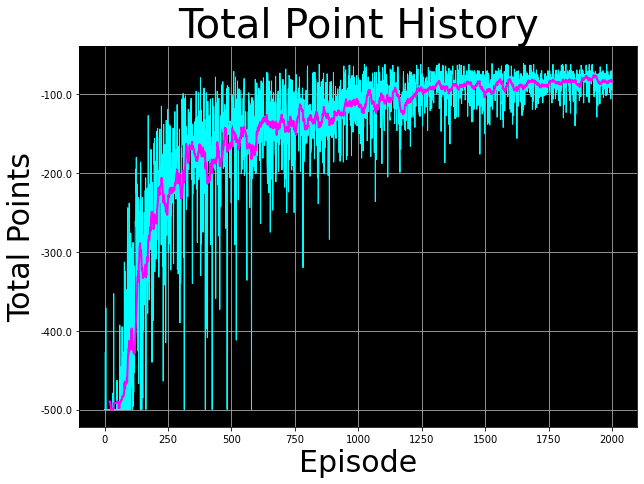

In [21]:
# Plot the point history
utils.plot_history(total_point_history)

In [22]:
import logging
logging.getLogger().setLevel(logging.ERROR)

In [23]:
filename = "./videos/acrobot.mp4"

utils.create_video(filename, env, q_network)
utils.embed_mp4(filename)

/usr/local/lib/python3.7/dist-packages/gym/core.py:44: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  "The argument mode in render method is deprecated; "
